In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from iminuit import Minuit, cost
import pandas as pd
from tqdm import tqdm

# Project 1

In [85]:
XMIN, XMAX = 0, 10
NBINS = 200

In [86]:
def params(data_type):
    '''data_type in order [V, tau, dm]'''
    if data_type == 'sig':
        return 0.1, 1.5, 20.0
    if data_type == 'bgd':
        return 0.0, 8, 0.0

# Create PDF Class 
## To generate psudo random values for this funtion:

$P(t; \tau, \delta m_s, V ) \propto (1 + V sin(\delta mt)) × e^{−t/\tau}$

Since it is proportional I will need to add a constant in front when fitting to normalise the function.


#### Maximum value of the function:

$\frac{\delta}{\delta t}(1 + V sin(\delta mt)) × e^{−t/\tau} 
= \frac{1}{\tau} e^{-t/\tau} (\delta m t V cos(\delta m t) - V sin(\delta mt)-1)$

at $t=0$, the function simply becomes,

$\frac{1}{\tau} (\delta m \tau V - 1) = \delta m V - 1/\tau$

In [117]:
class MyPDF:
    def __init__( self, lolimit, hilimit, V=0.1, tau=1.5, dm=20.0):
        self.lolimit = lolimit
        self.hilimit = hilimit
        self.V, self.tau, self.dm = V, tau, dm
        self.ts = []
        self.bin_centres = []
        self.y, self.minim = [], []


    ## Method to return value at point x unnormalised ##
    def evaluate(self, V, tau, dm):
        # return (1 + V*np.sin(dm*t)) * np.exp(-t/tau)
        return lambda x: (1+V*np.sin(dm*x))*np.exp(-x/tau)
    

    def calc_bin_centres(self):
        yvals, bin_edges = np.histogram(self.ts, NBINS, density=True) # normalised histogram
        for i in range(len(yvals)):
            self.bin_centres.append((bin_edges[i] + bin_edges[i+1])/2)
            

    def generate_data( self, nopoints=10000 ):
        p = self.evaluate(self.V, self.tau, self.dm)
        n = quad(p, self.lolimit, self.hilimit)[0]
        maxval = (self.dm * self.V - 1/self.tau) / n
        while (len(self.ts) < nopoints):
            ## start with uniform random number in [ XMIN , YMIN ] ##
            t = np.random.uniform( self.lolimit, self.hilimit ) # generate t value
            y1 = p(t) / n # calculate pdf value at t
            y2 = np.random.uniform(0, maxval) # generate random number between 0 and maxval
            if (y2 < y1):
                self.ts.append(t) # accept t value if less than maxval
        self.calc_bin_centres()

    ## Method of minimisation fit function ##
    def NLL( self, V, tau, dm ): 
        ## normalised expected values ##
        p = self.evaluate(V, tau, dm) 
        n = quad(p, self.lolimit, self.hilimit)[0]
        y = p(self.bin_centres) / n

        ## calculate lot likelihood ##
        return - np.sum(np.log(y))

In [116]:
pdf = MyPDF(XMIN, XMAX)
pdf.generate_data(10000)

## run Minuit ##
startvals = {'V': 0.1, 'tau': 1.5, 'dm': 20.0} 
m = Minuit(pdf.NLL, **startvals)
m.errordef = 0.5
m.limits['V'], m.limits['tau'], m.limits['dm'] =[0, 1], [0, 10], [0, 100] # limits on parameters V, tau and dm
m.migrad()

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

# Part 1

- Generate data by calling the generate_method in the Gaussian class
- Plot a histogram to check everything is working as expected

In [17]:
gauss = MyPDF( XMIN, XMAX )
gauss.generate_data(100000)

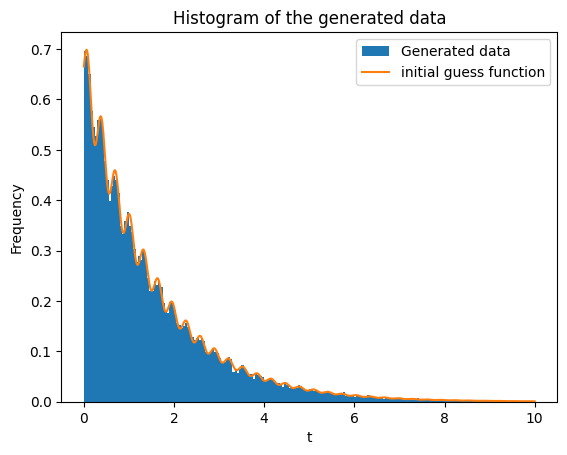

In [28]:
plt.hist(gauss.ts, bins=NBINS, density=True, label='Generated data')
x = np.linspace(XMIN, XMAX, 1000)
plt.plot(x, gauss.evaluate(x, *params('sig')) / gauss.norm, label='initial guess function')
plt.title('Histogram of the generated data')
plt.xlabel('t')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Maximum liklihood fit

In [36]:
def toy_MC(nots, nosims, V, tau, dm):
    mydict = {'V': [], 'Verr':[], 'tau': [], 'tauerr':[], 'dm': [], 'dmerr':[]} # dictionary to store results
    for i in tqdm(range(nosims)):
        pdf = MyPDF(XMIN, XMAX, *params('sig'))
        pdf.generate_data(nots)

        startvals = {'V': V, 'tau': tau, 'dm': dm} 
        m = Minuit(pdf.chi2, **startvals)
        m.errordef = 0.5
        m.limits['V'], m.limits['tau'], m.limits['dm'] =[0, 1], [0, 10], [0, 100] # limits on parameters V, tau and dm
        m.migrad()
        ## save values and errors ##
        mydict['V'].append(m.values['V']), mydict['Verr'].append(m.errors['V'])
        mydict['tau'].append(m.values['tau']), mydict['tauerr'].append(m.errors['tau'])
        mydict['dm'].append(m.values['dm']), mydict['dmerr'].append(m.errors['dm'])

    ## convert to dataframe ##
    df = pd.DataFrame(mydict)
    return df

In [35]:
df1 = toy_MC(10000, 10, *params('sig'))

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hanna\AppData\Local\Temp\ipykernel_41684\3216791902.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm))[0]
C:\Users\hanna\AppData\Local\Temp\ipykernel_41684\3216791902.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm))[0]
 17%|█▋        | 17/100 [01:22<06:41,  4.84s/it]


KeyboardInterrupt: 

In [ ]:
mean_params = df1.mean(axis=0)
std_params = df1.std(axis=0)

0    0.222454
1    0.223404
2    0.222308
3    0.224865
4    0.221482
5    0.222158
6    0.222513
7    0.223022
8    0.223853
9    0.220955
Name: Verr, dtype: float64


## Fit results from the MC simulation

In [ ]:
print('V: ', round(mean_params['V'], 3), ' +/- ', round(std_params['V'], 4))
print('tau: ', round(mean_params['tau'], 2), ' +/- ', round(std_params['tau'], 4))
print('d_m: ',round( mean_params['dm'], 3), ' +/- ', round(std_params['dm'], 4))

V:  0.098  +/-  0.0134
tau:  1.5  +/-  0.0174
d_m:  20.002  +/-  0.0817


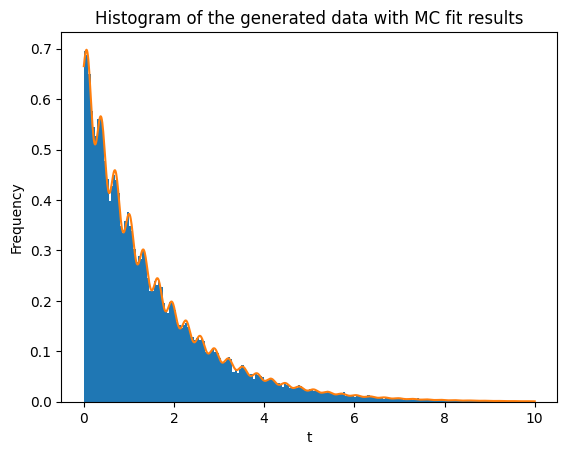

In [ ]:
plt.hist(gauss.ts, bins=NBINS, density=True, label='initial Generated data')
x = np.linspace(XMIN, XMAX, 1000)
plt.plot(x, gauss.evaluate(x, mean_params['V'], mean_params['tau'], mean_params['dm']) 
         / gauss.integrate(mean_params['V'], mean_params['tau'], mean_params['dm']), label='function')
plt.title('Histogram of the generated data with MC fit results')
plt.xlabel('t')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Part 2

In [ ]:
class SignalWithBackground:
    def __init__(self, nodatapoints, bgd_frac):
        self.nodata, self.bgd_frac = nodatapoints, bgd_frac
        self.ts = []
        self.ts_sig, self.ts_bgd = [], []
        self.sig_params = v_tau_dm('sig')
        self.bgd_params = v_tau_dm('bgd')
        self.signal = MyPDF(XMIN, XMAX, *self.sig_params)
        self.background = MyPDF(XMIN, XMAX, *self.bgd_params)
        self.signal.generate_data(nodatapoints)
        self.background.generate_data(nodatapoints)


    ## Create distribution given the background fraction ##
    def generate_mixed_data(self):
        sigcount, bgdcount = 0, 0
        while len(self.ts) < self.nodata:
            ## generate random number to determine which (sig, bgd) to take from ##
            q = np.random.uniform()
            if (q < (1 - self.bgd_frac)):
                ## take from Signal ##
                filtered_t = self.signal.ts[sigcount]
                self.ts_sig.append(filtered_t)
                sigcount += 1
            else:
                ## Take from Background ##
                filtered_t = self.background.ts[bgdcount]
                self.ts_bgd.append(filtered_t)
                bgdcount += 1
            self.ts.append(filtered_t)

    def combined_pdf(self):
        self.ts = ( (1 - self.bgd_frac) * np.array(self.signal.ts) ) + ( self.bgd_frac * np.array(self.background.ts) )
        self.ts_sig = ( (1 - self.bgd_frac) * np.array(self.signal.ts) )
        self.ts_bgd = ( self.bgd_frac * np.array(self.background.ts) )
        return self.ts


In [ ]:
def part_2_toy(V=0.1, tau=1.4, dm=20, nodatapoints=10000):
    ## V, tau, dm are stored in this order in the dictionary ##
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    plt.suptitle('Histogram of the generated data and fits', fontsize=23)
    fracs = {0:[], 0.1:[], 0.2:[], 0.3:[], 0.4:[]}
    axs_dim, count = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)], 0
    for frac in fracs:
        ## setting up the data ##
        mixed_sim = SignalWithBackground(nodatapoints, frac)
        mixed_sim.generate_mixed_data()
        pdf = MyPDF(XMIN, XMAX, *v_tau_dm('sig'))
        pdf.ts = mixed_sim.ts

        ## fitting the data with minuit ##
        startvals = {'V': V, 'tau': tau, 'dm': dm} 
        m = Minuit(pdf.chi2, **startvals)
        m.errordef = 0.5
        m.migrad()

        ## record values and errors to the dictionary ##
        fracs[frac].append(m.values['V']), fracs[frac].append(m.errors['V'])
        fracs[frac].append(m.values['tau']), fracs[frac].append(m.errors['tau'])
        fracs[frac].append(m.values['dm']), fracs[frac].append(m.errors['dm'])
                
        ## plotting the histogram and fit to check everthing is ok ##
        ax = axs[axs_dim[count]]
        ax.hist(mixed_sim.ts, bins=NBINS, density=True)
        x = np.linspace(XMIN, XMAX, 10000)
        ax.plot(x, pdf.evaluate(x, *m.values)/pdf.integrate(*m.values))
        ax.set_title('Background Fraction = ' + str(frac))
        ax.text(0.05, 0.95, 'V = ' + str(round(m.values['V'], 3)) + ' +/- ' + str(round(m.errors['V'], 3)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.text(0.05, 0.90, 'tau = ' + str(round(m.values['tau'], 2)) + ' +/- ' + str(round(m.errors['tau'], 3)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.text(0.05, 0.85, 'dm = ' + str(round(m.values['dm'], 3)) + ' +/- ' + str(round(m.errors['dm'], 2)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.set_xlabel('t'), ax.set_ylabel('Frequency')
        ax.set_xlim(XMIN, XMAX)
        count += 1
        print(f'fraction {frac} done)')
        
    ## removing the last subplot ##
    fig.delaxes(axs[1, 2])
    ## converting the dictionary to a dataframe ##
    df = pd.DataFrame(fracs).T
    return df

In [ ]:
df2 = part_2_toy()
df2.columns = ['V', 'Verr', 'tau', 'tauerr', 'dm', 'dmerr']

fraction 0 done)
fraction 0.1 done)


In [ ]:
df2

,V,tau,dm,Verr,tauerr,dmerr
0.0,0.092546,0.259034,1.513427,0.284875,20.003270,1.354496
0.1,0.089711,0.258228,1.910728,0.377702,19.950871,1.231477
0.2,0.046352,0.256502,2.304822,0.486704,22.538314,1.468273
0.3,0.024575,0.258565,2.872609,0.675541,17.806451,2.126350
0.4,0.030938,0.257745,3.491243,0.926080,19.104294,2.003548


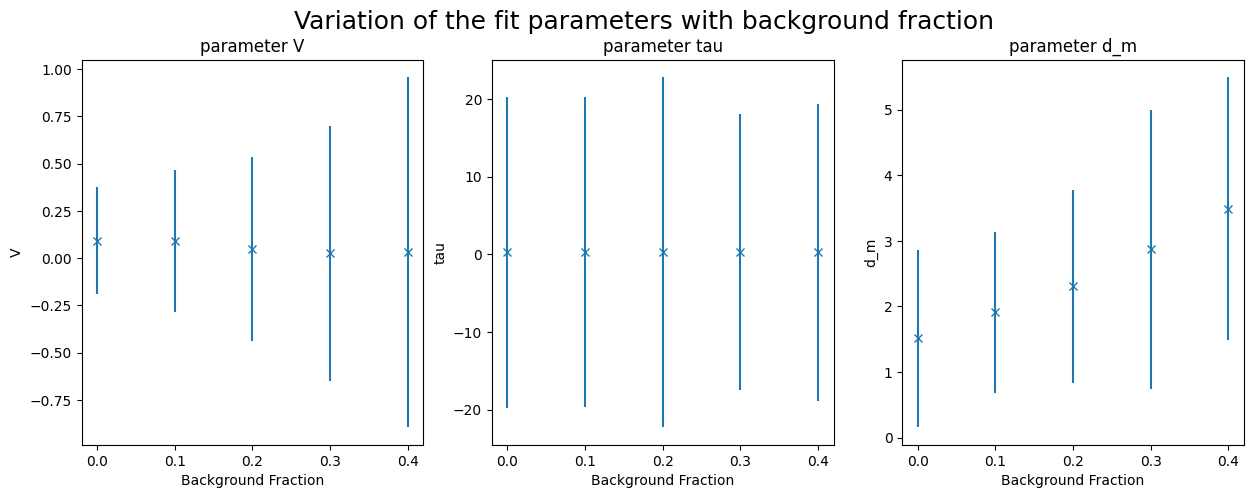

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].errorbar(df2.index, df2['V'], yerr=df2['Verr'], fmt='x')
axs[0].set_xlabel('Background Fraction')
axs[0].set_ylabel('V')
axs[0].set_title('parameter V')
axs[1].errorbar(df2.index, df2['tau'], yerr=df2['tauerr'], fmt='x')
axs[1].set_xlabel('Background Fraction')
axs[1].set_ylabel('tau')
axs[1].set_title('parameter tau')
axs[2].errorbar(df2.index, df2['dm'], yerr=df2['dmerr'], fmt='x')
axs[2].set_xlabel('Background Fraction')
axs[2].set_ylabel('d_m')
axs[2].set_title('parameter d_m')
plt.suptitle('Variation of the fit parameters with background fraction', fontsize=18)
plt.show()

## Biasies

In [ ]:
shifts = {'V':[], 'tau':[], 'dm':[]}

for i in df2.index:
    shifts['V'].append(mean_params['V'] - df2.loc[i, 'V'])
    shifts['tau'].append(mean_params['tau'] - df2.loc[i, 'tau'])
    shifts['dm'].append(mean_params['dm'] - df2.loc[i, 'dm'])

print(shifts)

{'V': [-0.00027695366217347916, 0.0025587678932455366, 0.04591693336816712, 0.06769414424733797, 0.06133179581520824], 'tau': [1.2476467613511242, 1.248452620836519, 1.250178342356729, 1.2481158035488598, 1.2489352417243875], 'dm': [18.48455922105215, 18.087258193763613, 17.693164013933263, 17.125377403305567, 16.5067428179107]}
